# **Irene Dovichi** 
## Midterm 2 - Assignment 3
Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1. Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2. Use the trained RBM to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3. Train a simple classifier (e.g. any simple classifier in scikit) to recognize the MNIST digits using as inputs their encoding obtained at step 2. Use the standard training/test split. Show a performance metric of your choice in the presentation/handout.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import idx2numpy
from tqdm import tqdm

## Dataset Loading

In [2]:
dataset_folder = 'mnist_db/'

# Load train and test images
train_images = idx2numpy.convert_from_file(os.path.join(dataset_folder, 'train-images-idx3-ubyte'))
test_images = idx2numpy.convert_from_file(os.path.join(dataset_folder, 't10k-images-idx3-ubyte'))

# Load train and test labels
train_labels = idx2numpy.convert_from_file(os.path.join(dataset_folder, 'train-labels-idx1-ubyte'))
test_labels = idx2numpy.convert_from_file(os.path.join(dataset_folder, 't10k-labels-idx1-ubyte'))

Image shape: (28, 28)
Pixel value range: 0 - 255
Label: 5


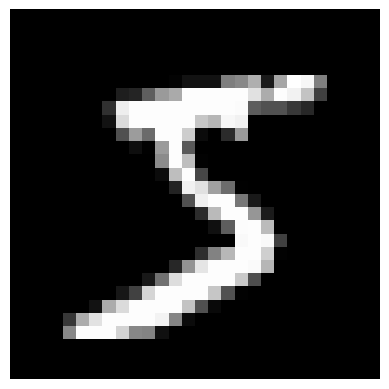

In [3]:
# Print the first image in the train set
first_image = train_images[0]
first_label = train_labels[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

# Print the label of the image
print("Label:", first_label)

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()


### Data Preprocessing

In [4]:
# Normalize pixel values
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Binarize the images
threshold = 0.5
train_images_b = np.where(train_images > threshold, 1, 0)
test_images_b = np.where(test_images > threshold, 1, 0)

# Reshape to 1D array
train_images_b = train_images_b.reshape(-1, 28*28)
test_images_b = test_images_b.reshape(-1, 28*28)

Image shape: (784,)
Pixel value range: 0 - 1


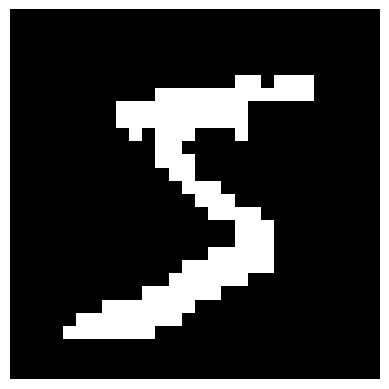

In [5]:
# See the change in the first image of the train set
first_image = train_images_b[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

## RBM Implementation 

In [11]:
class RBM:
    def __init__(self, visible_units, hidden_units, train_images):
        self.v = visible_units
        self.h = hidden_units
        self.train_images = train_images
        # Initialize weights to small random values taken from 0 mean gaussian with standard deviation 0.01
        self.W = np.random.randn(self.h, self.v) * 0.01
        # Initialize biases of visible units to log(p_i/(1-p_i)) where p_i is the proportion of training data where unit i is on
        self.bv = np.log((np.mean(self.train_images, axis=0) + 1e-5) / (1 - np.mean(self.train_images, axis=0) + 1e-5))
        # Initialize biases of hidden units to zero
        self.bh = np.zeros(self.h)
        self.epoch_errors = np.array([])
        self.errors = np.array([])

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def train(self, dataset, learning_rate, epochs, batch_size): 
        num_batches = len(dataset) // batch_size
        remainder = len(dataset) % batch_size

        for epoch in tqdm(range(epochs)):
            self.epoch_errors = []
            for i in range(num_batches):
                batch = dataset[i * batch_size : (i + 1) * batch_size]

                ## Compute wake part
                hidden_prob = self.sigmoid(np.dot(batch, self.W.T) + self.bh)
                wake = np.dot(hidden_prob.T, batch)

                ## Compute dream part
                # When the hidden units are being driven by the data, always use stochastic binary states
                hidden_states = np.random.rand(batch_size, self.h) < hidden_prob
                recon_prob = self.sigmoid(np.dot(hidden_states, self.W) + self.bv)
                # When they are being driven by reconstructions, always use probabilities without sampling
                recon_states = recon_prob
                hidden_prob_rec = self.sigmoid(np.dot(recon_states, self.W.T) + self.bh)
                dream = np.dot(hidden_prob_rec.T, recon_states)

                ## CD-1 update
                self.W += learning_rate * (wake - dream) / batch_size
                self.bv += learning_rate * (batch.sum(axis=0) - recon_states.sum(axis=0)) / batch_size
                self.bh += learning_rate * (hidden_prob.sum(axis=0) - hidden_prob_rec.sum(axis=0)) / batch_size

                ## Reconstruction error: MSE
                epoch_error = np.mean((batch - recon_states) ** 2)
                self.epoch_errors.append(epoch_error)

            if remainder > 0:
                batch = dataset[num_batches * batch_size :]

                ## Compute wake part
                hidden_prob = self.sigmoid(np.dot(batch, self.W.T) + self.bh)
                wake = np.dot(hidden_prob.T, batch)

                ## Compute dream part
                hidden_states = np.random.rand(remainder, self.h) < hidden_prob
                recon_prob = self.sigmoid(np.dot(hidden_states, self.W) + self.bv)
                recon_states = recon_prob
                hidden_prob_rec = self.sigmoid(np.dot(recon_states, self.W.T) + self.bh)
                dream = np.dot(hidden_prob_rec.T, recon_states)

                ## CD-1 update
                self.W += learning_rate * (wake - dream) / remainder
                self.bv += learning_rate * (batch.sum(axis=0) - recon_states.sum(axis=0)) / remainder
                self.bh += learning_rate * (hidden_prob.sum(axis=0) - hidden_prob_rec.sum(axis=0)) / remainder

                ## Reconstruction error: MSE
                remainder_error = np.mean((batch - recon_states) ** 2)
                self.epoch_errors.append(remainder_error)
            
            self.errors = np.append(self.errors, np.mean(self.epoch_errors))

    def reconstruct(self, data):
        hidden_prob = self.sigmoid(np.dot(data, self.W.T) + self.bh)
        recon_prob = self.sigmoid(np.dot(hidden_prob, self.W) + self.bv)
        return recon_prob

## RBM Training Phase

In [ ]:
#TODO: provare senza binarizzazione (usare train_images e test_images al posto di train/test_images_b --> fare il reshape a 1D vector)

Let's do a first try with RBM class to see if it is working

the number of `visible_units` is 784 since it is the length of the flattened MNIST images

In [17]:
rbm = RBM(visible_units=784, hidden_units=300, train_images=train_images_b)
rbm.train(dataset=train_images_b, learning_rate=0.1, epochs=50, batch_size=100)

100%|██████████| 50/50 [02:31<00:00,  3.03s/it]


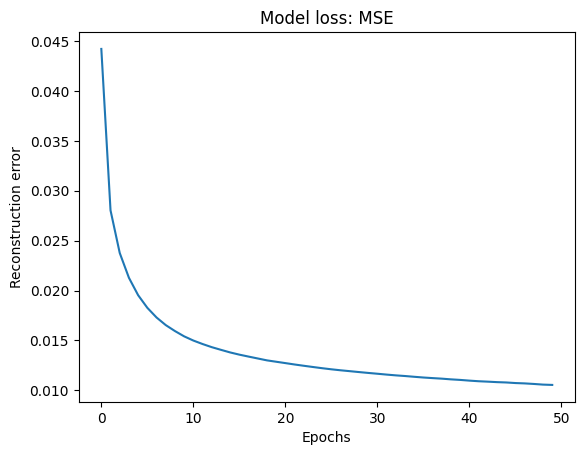

In [18]:
# plot the errors
plt.plot(rbm.errors)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.title('Model loss: MSE')
plt.show()

In [20]:
print('Final error:', rbm.errors[-1])

Final error: 0.010546683571769301


## Encoding Phase

## Classification Phase

## Personal Considerations